In [3]:
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
cst = tp.cst()
kHz = 1e3 * cst.h
twopi = 2 * np.pi

In [2]:


default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

# Volume Determination

In [15]:
# All relevant inputs 

x_var_name, x_var_label = 'HeatCycles', 'Heat Cycles (#)'
image_use = 'A'
import_params = ['ExpansionTime', 'HeatCycles', 'ShakingCycles']
settings = {**default_settings, 
            **dict(center_x = 1183, center_y = 1376, 
                   width=800, height=800, subsample=3, 
                   fudge=1.75, xsec_extension='linear', 
                   xsec_slice_width=3, xsec_fit_range=1.1, 
                   radial_selection=0.75,)}

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))


Total Images 3 ==> Good 3, Bad 0
Tc is at [ 100.] Heating Cycles
Box Length 90.76 +/- 0.24 um
Box Radius 60.28 +/- 0.14 um
Box Volume 1.036 +/- 0.005 x 10^-12 m^-3
Atom Nums  0.481 +/- 0.020 Millions
EF (kHz)   7.651 +/- 0.189 


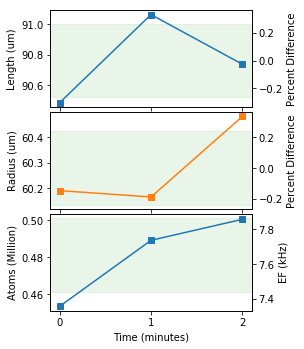

In [16]:
# Complete Volume Determination Prosedure 

# Load Images from Clipboard 
df_volume_all = tp.images_from_clipboard(df=pd.DataFrame() , 
                                  x=x_var_name, 
                                  params=import_params, 
                                  image_func=tp.Hybrid_Image, 
                                  download=image_use, display=False)

# Apply settings to all Images 
for n,r in df_volume_all.iterrows(): r.image.set(**settings)

# Atom number filter 
df_volume_all['total_atoms'] = [im.total_atoms for im in df_volume_all.image]
tp.atom_num_filter(df=df_volume_all, keep=0.15, offset=0.0, display=True, plot=False)
df_volume = df_volume_all[df_volume_all.use]

# Compute Box characteristics 
df_volume['nz_raw'] = [im.nz for im in df_volume.image]
df_volume['pz_raw'] = [tp.Curve(x = nz.x, y = np.arange(len(nz.x))) for nz in df_volume['nz_raw']]
df_volume['xsec_raw'] = [im.xsec for im in df_volume.image]
guess_ = [-45e-6, 45e-6, 5e-6, 5e-6]
df_volume['box_fit'] = [tp.curve_fit(tp.erf_box, guess_ + [nz.maxy, nz.maxy/1e3], *nz.data, ) for nz in df_volume['nz_raw']]
df_volume['length'] = [f[1] - f[0] for f in df_volume['box_fit']]
df_volume['top_ypixel'] = [r['pz_raw'](r['box_fit'].fv[1]) for n,r in df_volume.iterrows()]
df_volume['top_xpixel'] = [r['xsec_raw'].get_center(r['top_ypixel']) for n,r in df_volume.iterrows()]
df_volume['bottom_ypixel'] = [r['pz_raw'](r['box_fit'].fv[0]) for n,r in df_volume.iterrows()]
df_volume['bottom_xpixel'] = [r['xsec_raw'].get_center(r['bottom_ypixel']) for n,r in df_volume.iterrows()]
df_volume['center_ypixel'] = [r['pz_raw']((r['box_fit'].fv[0] + r['box_fit'].fv[1])/2) for n,r in df_volume.iterrows()]
df_volume['center_xpixel'] = [r['xsec_raw'].get_center(r['center_ypixel']) for n,r in df_volume.iterrows()]
df_volume['center_radius'] = [r['xsec_raw'].get_radius(r['center_ypixel']) for n,r in df_volume.iterrows()]
df_volume['nz_fixed'] = [tp.Curve(x = r.nz_raw.x, y = r.nz_raw.y - r.box_fit(amp=0), xscale=1e-6, yscale=1e18) for n,r in df_volume.iterrows()]
df_volume['nz_integral'] = [np.trapz(c.y, c.x) for c in df_volume['nz_fixed']]

# Extract results 
pixel_size_ = df_volume.image.iloc[0].pixel_binned
length_avg = tp.bin_data(df_volume.x.values, df_volume.length.values * 1e6)
radius_avg = tp.bin_data(df_volume.x.values, df_volume.center_radius.values * pixel_size_ * 1e6)
volume_avg = tp.bin_data(df_volume.x.values, length_avg.yi * np.pi * radius_avg.yi**2 / 1e18)
atoms_avg = tp.bin_data(df_volume.x.values, df_volume.total_atoms.values / 1e6)
EF_avg = tp.bin_data(df_volume.x.values, cst.n2EF( atoms_avg.yi * 1e6 / volume_avg.yi ))

# Print Highlights 
print("Tc is at {} Heating Cycles".format(np.unique(df_volume.x)))
print("Box Length {:.2f} +/- {:.2f} um".format(length_avg.y[0], length_avg.ystd[0]))
print("Box Radius {:.2f} +/- {:.2f} um".format(radius_avg.y[0], radius_avg.ystd[0]))
print("Box Volume {:.3f} +/- {:.3f} x 10^-12 m^-3".format(volume_avg.y[0] * 1e12, volume_avg.ystd[0] * 1e12))
print("Atom Nums  {:.3f} +/- {:.3f} Millions".format(atoms_avg.y[0], atoms_avg.ystd[0]))
print("EF (kHz)   {:.3f} +/- {:.3f} ".format(EF_avg.y[0]/kHz, EF_avg.ystd[0]/kHz))

# Make figure 
time = np.array(list(df_volume.time.values))
time_str = ['{:.0f}'.format(t) for t in time]
xcount = np.arange(df_volume.shape[0])

ax = plt.subplots(nrows=3, figsize=[4.5, 5], sharex=True)[1]
plt.sca(ax[0])
plt.plot(xcount, length_avg.yi, 's-')
plt.axhspan(length_avg.y - length_avg.ystd, 
            length_avg.y + length_avg.ystd, 
            alpha=0.1, color='C2')
ax_ = ax[0].twinx()
ax_.set(ylim = 100*(np.array(ax[0].get_ylim())/(length_avg.y[0])-1),
        ylabel = 'Percent Difference')
ax[0].set(ylabel=r'Length (um)', 
          xticks=xcount, xticklabels=time_str)

plt.sca(ax[1])
plt.plot(xcount, radius_avg.yi, 's-C1')
plt.axhspan(radius_avg.y - radius_avg.ystd, 
            radius_avg.y + radius_avg.ystd, 
            alpha=0.1, color='C2')
ax[1].set(ylabel=r'Radius (um)', 
          xticks=xcount, xticklabels=time_str)
ax_ = ax[1].twinx()
ax_.set(ylim = 100*(np.array(ax[1].get_ylim())/radius_avg.y[0]-1),
        ylabel = 'Percent Difference')

plt.sca(ax[2])
plt.plot(xcount, atoms_avg.yi, 's-')
plt.axhspan(atoms_avg.y - atoms_avg.ystd, 
            atoms_avg.y + atoms_avg.ystd, 
            alpha=0.1, color='C2')
ax[2].set(ylabel=r'Atoms (Million)', 
          xticks=xcount, xticklabels=time_str)
ax_ = ax[2].twinx()
ax_.set(ylim = cst.n2EF(np.array(ax[2].get_ylim()) * 1e6 / volume_avg.y)/kHz,
        ylabel = 'EF (kHz)')

ax[-1].set_xlabel('Time (minutes)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)

In [17]:
# All relevant inputs 

x_var_name, x_var_label = 'HeatCycles', 'Heat Cycles (#)'
image_use = 'A'

settings = {**default_settings, 
            **dict(center_x = 1183, center_y = 1376, 
                   fudge=1.75, width=800, height=1500, 
                   subsample=3,
                   radial_selection=0.75,
                   Tfit_lim=0.1)}

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))


Total Images 4 ==> Good 4, Bad 0
Tc is at [ 100.] Heating Cycles
Total s1 atoms 0.46 millions
Difference in E/E0 0.13, which is 19 %
Difference in E/N  0.59 kHz
Total energy to subtract 0.27 X 10^6 kHz


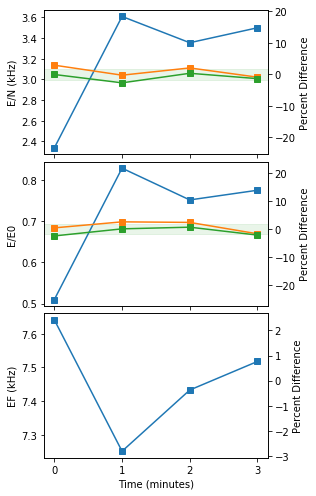

In [18]:
# Complete Energy Determination 

# Compute E/N 
def compute_moment(nz, zlim=550, trap_f=settings['trap_f']):
    mult = 4 * 1/2 * cst.mass * (twopi*trap_f)**2
    using = (nz.x >= -zlim*1e-6) & (nz.x <= zlim*1e-6)
    nz = tp.Curve(nz.x[using], nz.y[using])
    return mult * np.trapz(nz.y*nz.x**2, nz.x) / np.trapz(nz.y, nz.x)

# Load images from clipboard 
df_hyb_energy_all = tp.images_from_clipboard(df=pd.DataFrame(),
                                         x=x_var_name, 
                                         params=import_params,
                                         image_func=tp.Hybrid_Image,
                                         download=image_use,
                                         display=False)

# Apply settings to all 
for n,r in df_hyb_energy_all.iterrows(): r.image.set(**settings)
    
# Atom Number filter 
df_hyb_energy_all['total_atoms'] = [im.total_atoms for im in df_hyb_energy_all.image]
tp.atom_num_filter(df=df_hyb_energy_all, keep=0.1, offset=0.0, display=True, plot=False)
df_hyb_energy = df_hyb_energy_all[df_hyb_energy_all.use]

# Fit Hybrid UFG 
if True: 
    guess = dict(kT_kHz = settings['Tfit_guess_kT'],
                 mu0_kHz = settings['Tfit_guess_mu0'],)
    fixed = dict(trap_f=df_hyb_energy.iloc[0].image.trap_f, z0=0, fudge=1, offset=0, gradient=0)
    df_hyb_energy['nz_curvefit'] = [tp.curve_fit(tp.density_unitary_hybrid, guess, 
                               *img.nz.trim(ylim=[-np.inf, settings['Tfit_lim']*1e18]).data,
                                fixed = fixed)
                              for img in df_hyb_energy.image]

    # Compute nz stitched 
    df_hyb_energy['nz_data'] = None
    df_hyb_energy['nz_fit'] = None
    df_hyb_energy['nz_stitched'] = None
    for n, r in df_hyb_energy.iterrows():
        z, n_data = r.image.nz.x, r.image.nz.y
        n_fit = r.nz_curvefit(z)
        use_fit = (n_fit <= settings['Tfit_lim'] * 1e18)
        n_stitched = n_data.copy()
        n_stitched[use_fit] = n_fit[use_fit]
        df_hyb_energy.loc[n, 'nz_data'] = tp.Curve(z, n_data, xscale=1e-6, yscale=1e18)
        df_hyb_energy.loc[n, 'nz_fit'] = tp.Curve(z, n_fit, xscale=1e-6, yscale=1e18)
        df_hyb_energy.loc[n, 'nz_stitched'] = tp.Curve(z, n_stitched, xscale=1e-6, yscale=1e18)
    
# Get box volume from above 
box_volume = volume_avg.y[0]

# Compute atom numbers 
if True: 
    time = np.array(list(df_hyb_energy.time.values))
    time_str = ['{:.0f}'.format(t) for t in time]
    xi = df_hyb_energy.x.values
    xcount = np.arange(df_hyb_energy.shape[0])

    # Total Atoms from atom counting 
    atoms_fit_data_ratio = np.array([r.nz_fit.y.sum()/r.nz_data.y.sum() for n,r in df_hyb_energy.iterrows()]) 
    atoms_counting_data = np.array([r.image.total_atoms for n,r in df_hyb_energy.iterrows()]) 
    atoms_counting_fit = atoms_counting_data * atoms_fit_data_ratio
    EF_counting_data = cst.n2EF(atoms_counting_data / box_volume)
    EF_counting_fit = cst.n2EF(atoms_counting_fit / box_volume)

    # Total Atoms from nz integration
    mult = np.pi * df_hyb_energy.iloc[0].image.pixel_binned**2
    atoms_nzint_data = np.array([ np.trapz(r.nz_data.y * r.image.xsec.radius**2, r.nz_data.x)
        for n,r in df_hyb_energy.iterrows()]) * mult
    atoms_nzint_fit = np.array([ np.trapz(r.nz_fit.y * r.image.xsec.radius**2, r.nz_fit.x)
        for n,r in df_hyb_energy.iterrows()]) * mult
    EF_nzint_data = cst.n2EF(atoms_nzint_data / box_volume)
    EF_nzint_fit = cst.n2EF(atoms_nzint_fit / box_volume)

    # Average 
    atoms_avg = tp.bin_data(
            np.concatenate([np.arange(len(atoms_counting_data))] * 4),
            np.concatenate([atoms_counting_data, atoms_counting_fit, 
                            atoms_nzint_data, atoms_nzint_fit]))
    EF_avg = tp.bin_data(atoms_avg.xi, cst.n2EF(atoms_avg.yi/box_volume))

# Compute E/N and E/E0 
if True: 
    # Compute E/N different ways 
    EN_data = np.array([compute_moment(nz) 
               for nz in df_hyb_energy.nz_data])
    EN_fit = np.array([compute_moment(nz) 
               for nz in df_hyb_energy.nz_fit])
    EN_stitched = np.array([compute_moment(nz) 
               for nz in df_hyb_energy.nz_stitched])

    # Compute E/E0 
    EE0_data = EN_data/(3/5 * EF_avg.y)
    EE0_fit = EN_fit/(3/5 * EF_avg.y)
    EE0_stitched = EN_stitched/(3/5 * EF_avg.y)

    # Average E/N from fit and stitched methods 
    EN_avg = tp.bin_data(np.concatenate([xi]*2), 
               np.concatenate([EN_fit, EN_stitched]))

    # Compute E/E0 
    EE0_avg = tp.bin_data(np.concatenate([xi]*2), 
               np.concatenate([EE0_fit, EE0_stitched]))

# Print Highlights 
if True: 
    EE0_subtract = EE0_avg.y[0] - 0.55
    EE0_subtract_percent = EE0_subtract / EE0_avg.y[0] * 100
    EN_subtract = EE0_subtract * (3/5 * EF_avg.y.mean())
    E_subtract = EN_subtract * atoms_avg.y.mean()
    print("Tc is at {} Heating Cycles".format(np.unique(df_hyb_energy.x)))
    print("Total s1 atoms {:.2f} millions".format(atoms_avg.y.mean()/1e6))
    print("Difference in E/E0 {:.2f}, which is {:.0f} %".format(EE0_subtract, EE0_subtract_percent))
    print("Difference in E/N  {:.2f} kHz".format(EN_subtract/kHz))
    print("Total energy to subtract {:.2f} X 10^6 kHz".format(E_subtract/kHz/1e6))

# Make figure 
if True: 
    ax = plt.subplots(nrows=3, figsize=[4.5, 7], sharex=True)[1]
    plt.sca(ax[0])
    plt.plot(xcount, EN_data/kHz, 's-')
    plt.plot(xcount, EN_fit/kHz, 's-')
    plt.plot(xcount, EN_stitched/kHz, 's-')
    plt.axhspan(EN_avg.y/kHz - EN_avg.ystd/kHz, 
                EN_avg.y/kHz + EN_avg.ystd/kHz, 
                alpha=0.1, color='C2')
    ax_ = ax[0].twinx()
    ax_.set(ylim = 100*(np.array(ax[0].get_ylim())/(EN_avg.y/kHz)-1),
            ylabel = 'Percent Difference')
    ax[0].set(ylabel=r'E/N (kHz)', 
              xticks=xcount, xticklabels=time_str)
    plt.sca(ax[1])
    plt.plot(xcount, EE0_data, 's-')
    plt.plot(xcount, EE0_fit, 's-')
    plt.plot(xcount, EE0_stitched, 's-')
    plt.axhspan(EE0_avg.y - EE0_avg.ystd, 
                EE0_avg.y + EE0_avg.ystd, 
                alpha=0.1, color='C2')
    ax[1].set(ylabel=r'E/E0', 
              xticks=xcount, xticklabels=time_str)
    ax_ = ax[1].twinx()
    ax_.set(ylim = 100*(np.array(ax[1].get_ylim())/EE0_avg.y-1),
            ylabel = 'Percent Difference')
    plt.sca(ax[2])
    plt.plot(xcount, EF_avg.y/kHz, 's-')
    ax[2].set(ylabel=r'EF (kHz)', xlabel=r'Time (minutes)', 
              xticks=xcount, xticklabels=time_str)
    ax_ = ax[2].twinx()
    ax_.set(ylim = 100*(np.array(ax[2].get_ylim())/(EF_avg.y.mean()/kHz)-1),
            ylabel = 'Percent Difference')


    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)